# Import packages

In [3]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

### Importing data

In [4]:
# assign dataset names
datasets = ['202208-divvy-tripdata','202207-divvy-tripdata','202206-divvy-tripdata',
            '202205-divvy-tripdata','202204-divvy-tripdata','202203-divvy-tripdata',
            '202202-divvy-tripdata','202201-divvy-tripdata','202112-divvy-tripdata',
            '202111-divvy-tripdata','202110-divvy-tripdata','202109-divvy-tripdata']
            
df_list = []
 
# append datasets into the list
for i in range(len(datasets)):
    temp_df = pd.read_csv(datasets[i]+".csv")
    df_list.append(temp_df)

###  Merge all dataset

Creating a new dataframe with all data also can help the process to be more quick

In [5]:
# Merged all monthly dataset into one
year_df = pd.concat(df_list)

In [6]:
year_df.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5883043 entries, 0 to 756146
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 3.6 GB


### Reducing file size

The memory usage had a huge increase compared to the csv file. This problem is caused by the objects data type in some of columns, due the fact there's mutiple datatypes sharing the same column. 
 - For now, we can see the column "member_casual" and "rideable_type" can fit better as a category data type, due the fact there's a limited possibility of value. 
 - We also can modify the ids data type into a more efficient format

In [7]:
year_df['rideable_type'] = year_df['rideable_type'].astype('category')
year_df['member_casual'] = year_df['member_casual'].astype('category')

In [8]:
year_df.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5883043 entries, 0 to 756146
Data columns (total 13 columns):
 #   Column              Dtype   
---  ------              -----   
 0   ride_id             object  
 1   rideable_type       category
 2   started_at          object  
 3   ended_at            object  
 4   start_station_name  object  
 5   start_station_id    object  
 6   end_station_name    object  
 7   end_station_id      object  
 8   start_lat           float64 
 9   start_lng           float64 
 10  end_lat             float64 
 11  end_lng             float64 
 12  member_casual       category
dtypes: category(2), float64(4), object(7)
memory usage: 2.9 GB


Our memory usage had a good decrease.

### Check for duplicate values

In [9]:
year_df.count()

ride_id               5883043
rideable_type         5883043
started_at            5883043
ended_at              5883043
start_station_name    4998678
start_station_id      4998680
end_station_name      4936740
end_station_id        4936740
start_lat             5883043
start_lng             5883043
end_lat               5877316
end_lng               5877316
member_casual         5883043
dtype: int64

In [10]:
for i in year_df.columns:
    print(f"{i}: {year_df[i].nunique()}")

ride_id: 5883043
rideable_type: 3
started_at: 4912339
ended_at: 4919944
start_station_name: 1438
start_station_id: 1272
end_station_name: 1452
end_station_id: 1281
start_lat: 569819
start_lng: 541128
end_lat: 281345
end_lng: 264402
member_casual: 2


Seeing the unique values in comparison to the total count of the dataset, we can see our ride_id is pretty unique, but we have some inconsistency in the "station name" and the "station id",
- start_station_name: 1438
- start_station_id: 1272  
  
- end_station_name: 1452
- end_station_id: 1281  
  
Let's do a further analysis to see what is causing this difference.

In [11]:
def get_inconsistent_ids_series() -> pd.Series:
    """Get a pandas series of stations sharing the same ID and their value counts"""
    start_ids_sr = year_df.groupby(['start_station_id','start_station_name']).size().rename_axis(index={'start_station_id': 'id', 'start_station_name': 'station_name'})
    end_ids_sr = year_df.groupby(['end_station_id','end_station_name']).size().rename_axis(index={'end_station_id': 'id', 'end_station_name': 'station_name'})

    vc1 = start_ids_sr.reset_index()['id'].value_counts()
    vc2 = end_ids_sr.reset_index()['id'].value_counts()

    start_ids_with_many_names = vc1[vc1 > 1].index
    end_ids_with_many_names = vc2[vc2 > 1].index

    start_mask = start_ids_sr.index.get_level_values(0).isin(start_ids_with_many_names)
    start_ids_sr[start_mask]
    end_mask = end_ids_sr.index.get_level_values(0).isin(end_ids_with_many_names)
    end_ids_sr[end_mask]

    return pd.concat([start_ids_sr[start_mask], end_ids_sr[end_mask]], axis = 0)

inconsistent_ids_series = get_inconsistent_ids_series()
print("Number of station IDs with more than one name associated with it:", len(inconsistent_ids_series))
inconsistent_ids_series.head(20)

Number of station IDs with more than one name associated with it: 697


id     station_name                                 
13053  Green St & Randolph St                           11658
       Green St & Washington Blvd                        1221
13059  Bissell St & Armitage Ave                        13296
       Sheridan Rd & Argyle St                           1471
13099  Halsted St & 18th St                              2877
       Halsted St & 18th St (Temp)                       1316
15541  Buckingham Fountain                               7675
       Buckingham Fountain (Temp)                        2437
303    Kildare Ave & Division St                          113
       Public Rack - Kildare Ave & Division St             44
444    N Shore Channel Trail & Argyle Ave                  11
       N Shore Channel Trail & Argyle St                  571
478    California Ave & Touhy Ave - SW                      1
       Public Rack - California Ave & Touhy Ave - SW        3
479    California Ave & Touhy Ave - NW                     14
       Public Rac

We see all the station's name is very similar when they share the same id, but with some variation probably caused by the influence of renaming, relocation and other events. We can stay this as it is and move on assuming is not an error caused by wrong data collected. 

###  Null values check

In [12]:
#checking null values
year_df.isnull().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    884365
start_station_id      884363
end_station_name      946303
end_station_id        946303
start_lat                  0
start_lng                  0
end_lat                 5727
end_lng                 5727
member_casual              0
dtype: int64

All the missing values was found in the station identifiers, we can use the latitude and longitude of matching rows to see if we can find the missing values in the name and id stations.

In [13]:
# assigning the null values using the matches latitutde and longitude of other rows
year_df['start_station_name'] = year_df.groupby(['start_lat','start_lng'], sort=False).bfill()['start_station_name']
year_df['start_station_id'] = year_df.groupby(['start_station_name','start_lat','start_lng'], sort=False).bfill()['start_station_id']
year_df['end_station_name'] = year_df.groupby(['end_lat','end_lng'], sort=False).bfill()['end_station_name']
year_df['end_station_id'] = year_df.groupby(['end_station_name','end_lat','end_lng'], sort=False).bfill()['end_station_id']



In [14]:
#checking null values
year_df.isnull().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    636530
start_station_id      636530
end_station_name      712590
end_station_id        712590
start_lat                  0
start_lng                  0
end_lat                 5727
end_lng                 5727
member_casual              0
dtype: int64

We filled amost 250k of missing values in each column, and now we have around 10% of data being missed in the dataset, 
There's no other way to fill the missing values with reliable information, so the better option here is to drop all rows
with missing value.

In [15]:
#collect a sample from the null values group to see if there's a pattern or is made with random rows
unique_sample_confirmation = year_df[year_df['start_station_name'].isna()].sample(50)
unique_sample_confirmation['started_at'].unique()

array(['2022-03-24 11:02:20', '2022-05-11 18:29:21',
       '2022-06-25 13:41:36', '2022-06-29 19:14:07',
       '2022-05-04 07:01:29', '2022-05-26 12:10:25',
       '2022-06-24 18:41:51', '2022-03-10 17:08:56',
       '2021-10-21 16:59:14', '2021-09-08 19:26:55',
       '2021-09-18 20:22:33', '2022-04-15 23:23:13',
       '2021-09-01 16:51:42', '2021-09-26 17:20:28',
       '2022-08-20 13:56:10', '2021-09-17 14:46:16',
       '2021-09-23 11:59:23', '2022-04-19 14:13:46',
       '2022-07-31 21:30:16', '2021-11-05 19:44:36',
       '2021-09-05 18:49:04', '2021-09-03 11:31:06',
       '2021-09-13 16:52:21', '2022-07-01 14:18:43',
       '2022-07-31 10:34:39', '2022-05-31 17:52:23',
       '2022-07-23 14:08:58', '2021-12-11 12:45:50',
       '2021-11-27 18:48:21', '2021-10-10 14:56:46',
       '2021-12-19 19:12:41', '2022-04-15 19:21:07',
       '2022-04-01 00:49:36', '2022-05-13 22:33:41',
       '2022-08-18 20:13:53', '2021-12-29 16:20:57',
       '2022-07-11 19:23:07', '2022-07-01 18:0

We confirm the missing is not bias and drop them will not influence the conclusion.

In [16]:
year_df = year_df.dropna()

In [17]:
year_df.isnull().sum()

ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
start_station_id      0
end_station_name      0
end_station_id        0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
member_casual         0
dtype: int64

### Add ride length column

In [18]:
# add a column to show the ride length
year_df['started_at'] = pd.to_datetime(year_df['started_at'], errors='coerce')
year_df['ended_at'] = pd.to_datetime(year_df['ended_at'], errors='coerce')
year_df['ride_length']= year_df['ended_at'] - year_df['started_at']

### Checking possible negative durations

In [19]:
neg_length = year_df['ride_length'] < pd.Timedelta("0 days")
print("Number of rows with negative ride durations:", len(year_df.loc[neg_length]))

Number of rows with negative ride durations: 110


There's some negative ride durations, data was wrongly registered, let's drop these data because it can compromise our conclusions.

In [20]:
year_df = year_df.loc[~neg_length]
neg_length = year_df['ride_length'] < pd.Timedelta("0 days")
print("Number of rows with negative ride durations:", len(year_df.loc[neg_length]))

Number of rows with negative ride durations: 0


In [21]:
# add a column with the weekday
year_df['day_of_week'] = year_df['started_at'].dt.strftime("%A")
year_df['weekday_number'] = year_df['started_at'].dt.dayofweek

In [22]:
year_df['day_of_week'].value_counts()

Saturday     801084
Sunday       698736
Wednesday    693768
Thursday     686809
Tuesday      672842
Friday       668215
Monday       634866
Name: day_of_week, dtype: int64

In [23]:
year_df.head()


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_length,day_of_week,weekday_number
0,550CF7EFEAE0C618,electric_bike,2022-08-07 21:34:15,2022-08-07 21:41:46,Elston Ave & George St,472,Public Rack - Milwaukee Ave & Haussen Ct,505,41.93,-87.69,41.94,-87.72,casual,0 days 00:07:31,Sunday,6
3,F597830181C2E13C,electric_bike,2022-08-08 02:43:50,2022-08-08 02:58:53,N Sheffield Ave & W Wellington Ave,20256.0,Western Ave & Gunnison St,445,41.94,-87.65,41.97,-87.69,casual,0 days 00:15:03,Monday,0
5,BFA7E7CC69860C20,electric_bike,2022-08-08 13:06:08,2022-08-08 13:19:09,Komensky Ave & 55th St,347,Rockwell St & Archer Ave,379,41.79,-87.72,41.82,-87.69,casual,0 days 00:13:01,Monday,0
10,1749361AC24EFB77,electric_bike,2022-08-07 20:32:48,2022-08-07 20:35:38,Wood St & 103rd St,694,Western Ave & 100th St,695,41.71,-87.67,41.71,-87.68,casual,0 days 00:02:50,Sunday,6
17,7CB3ACA2D8916A84,electric_bike,2022-08-08 15:47:42,2022-08-08 16:05:22,Cottage Grove Ave & 89th Pl,879,Public Rack - Jeffery Blvd & 81st St,944,41.73,-87.60,41.75,-87.58,casual,0 days 00:17:40,Monday,0


###  Split annual dataset by user type

Spliting the dataset divided by the type of member can help us to get more insights bout the trends of each user type.

In [24]:
casual_df = year_df.loc[year_df['member_casual']=='casual']
member_df = year_df.loc[year_df['member_casual']=='member']

# Analyzing data

###  Count of ride by weekday of the last year

Text(0.5, 1.0, '09/2021 to 08/2022')

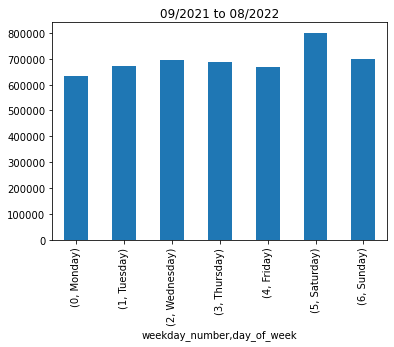

In [25]:
# plotting the annual count of rides by week 
year_df[['weekday_number', 'ride_id', 'day_of_week']].groupby(['weekday_number', 'day_of_week']).count().sort_index().plot(kind='bar', legend=None)

plt.title("09/2021 to 08/2022")
   

###  Count of rides by weekday of each type of user

Text(0.5, 1.0, 'Member usage from 09/2021 to 08/2022')

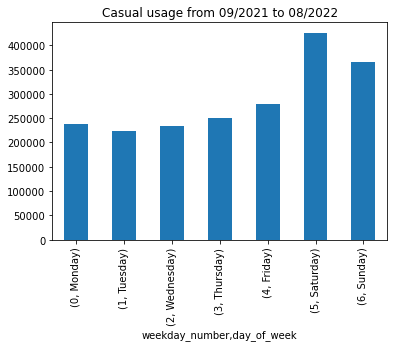

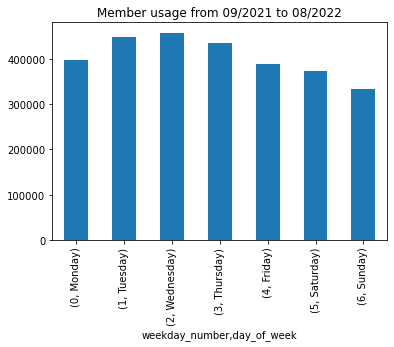

In [26]:
# plotting the count of rides by weekday of each type of user
casual_df[['weekday_number', 'ride_id', 'day_of_week']].groupby(['weekday_number', 'day_of_week']).count().sort_index().plot(kind='bar', legend=None)
plt.title("Casual usage from 09/2021 to 08/2022")

member_df[['weekday_number', 'ride_id', 'day_of_week']].groupby(['weekday_number', 'day_of_week']).count().sort_index().plot(kind='bar', legend=None)
plt.title("Member usage from 09/2021 to 08/2022")



###  Ride length average in each user type

In [27]:
year_df[['member_casual', 'ride_length']].groupby(['member_casual']).mean()

,ride_length
member_casual,
casual,0 days 00:25:04.981344226
member,0 days 00:12:32.693974601


Found the ride lenght mean value of each member type.  
Casual member use to do a longer travel than our members.

###  The biggest ride length in each user type

In [28]:
year_df[['member_casual', 'ride_length']].groupby(['member_casual']).max()

,ride_length
member_casual,
casual,28 days 06:25:01
member,1 days 00:59:54


###  Average ride length by weekday

### - Casual user 

In [29]:
# ride length average by each day of week
casual_df[['weekday_number', 'day_of_week', 'ride_length']].groupby(['weekday_number','day_of_week']).mean().sort_index()

,,ride_length
weekday_number,day_of_week,
0,Monday,0 days 00:25:58.504218715
1,Tuesday,0 days 00:21:56.884655799
2,Wednesday,0 days 00:21:29.858298508
3,Thursday,0 days 00:22:09.425344090
4,Friday,0 days 00:23:21.678896451
5,Saturday,0 days 00:27:41.234198850
6,Sunday,0 days 00:29:00.155585401


### - Member user 

In [30]:
member_df[['weekday_number', 'day_of_week', 'ride_length']].groupby(['weekday_number', 'day_of_week']).mean().sort_index()


,,ride_length
weekday_number,day_of_week,
0,Monday,0 days 00:12:09.626964963
1,Tuesday,0 days 00:11:49.807387282
2,Wednesday,0 days 00:11:56.359438892
3,Thursday,0 days 00:12:03.442484237
4,Friday,0 days 00:12:16.650273364
5,Saturday,0 days 00:14:01.231432649
6,Sunday,0 days 00:14:05.497288118


### Count of Rides by month of each type of user 

/var/folders/88/knx7zw015qbbjy6wrxv2zrsc0000gn/T/ipykernel_2488/1614075805.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  casual_df.groupby(casual_df.started_at.dt.to_period("M"))['ride_id','member_casual'].count().plot(kind='line', legend=None)
/var/folders/88/knx7zw015qbbjy6wrxv2zrsc0000gn/T/ipykernel_2488/1614075805.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  member_df.groupby(member_df.started_at.dt.to_period("M"))['ride_id','member_casual'].count().plot(kind='line', legend=None)
/var/folders/88/knx7zw015qbbjy6wrxv2zrsc0000gn/T/ipykernel_2488/1614075805.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  year_df.groupby(year_df.started_at.dt.to_period("M"))['ride_id','member_casual'].count().plot(kind='line', legend=None)


Text(0.5, 1.0, 'Rides total by month 09/2021 to 08/2022')

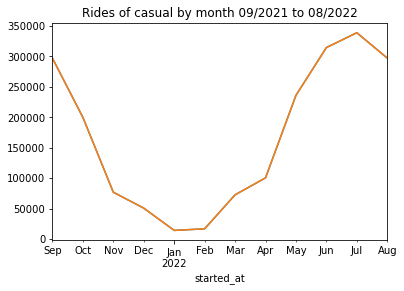

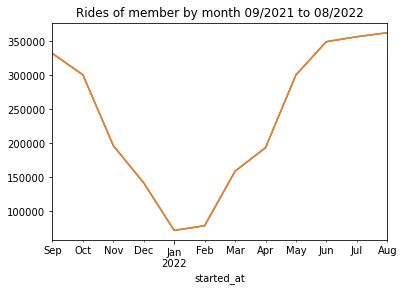

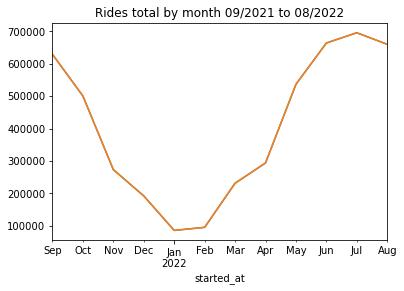

In [31]:
# plotting the rides by month of each type of member
casual_df.groupby(casual_df.started_at.dt.to_period("M"))['ride_id','member_casual'].count().plot(kind='line', legend=None)
plt.title("Rides of casual by month 09/2021 to 08/2022")

member_df.groupby(member_df.started_at.dt.to_period("M"))['ride_id','member_casual'].count().plot(kind='line', legend=None)
plt.title("Rides of member by month 09/2021 to 08/2022")

year_df.groupby(year_df.started_at.dt.to_period("M"))['ride_id','member_casual'].count().plot(kind='line', legend=None)
plt.title("Rides total by month 09/2021 to 08/2022")



This line graph with the total rides by month shows a lot of information, some insight we can extract from those are:  
*We had a decline of usage when we approach to the end of the year (maybe because the winter season),  
*January was the worst month of the last year,
*July was the best month in the last year,  
*The ride numbers made by members is always higher than the casual, the diference is bigger in the weak months.

It's clear the usage of the bikes follows the season of the year, add data of the average temperature of the city can help us see how this correlation works.

 (For this study, I used data from weatherspark.com)

<AxesSubplot:xlabel='Month'>

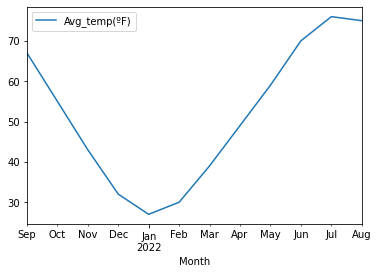

In [56]:
data = {'month': ['Sep 21', 'Oct 21','Nov 21', 'Dec 21', 'Jan 22', 'Feb 22', 'Mar 22', 'Apr 22', 'May 22', 'Jun 22', 'Jul 22', 'Aug 22'], 
        'avg_temp(ºF)': [67, 55, 43, 32, 27, 30, 39, 49, 59, 70, 76, 75]}
temp = pd.DataFrame(data)
temp['month'] = pd.to_datetime(temp['month'], format="%b %y")

temp.plot(x='month', y='avg_temp(ºF)', kind='line')

In [87]:
# Adding the average temperature to the dataset
for i in range(12):
    year_df.loc[(year_df['started_at'].dt.month == temp.iloc[i]['month'].month), "avg_temp"] = temp.iloc[i]["avg_temp(ºF)"] 

In [89]:
# saving as csv file
year_df.to_csv(r'Year-divvy-tripdata_cleaned.csv', index=False)
print('DataFrame is written to CSV File successfully.')


DataFrame is written to CSV File successfully.
